# Load Data

In [70]:
# The Grid Search included in this Code will run on all cores and takes about 4 hours.
# However, it is not necessary to run Grid Search to see the results.
# It is possible to run everything until Grid Search and then run the comparism of the experiments
# because the best parameters obtained by Grid Seach are hard coded as well.

import pandas as pd
import numpy as np

df = pd.read_csv("GT_intention.csv")
with pd.option_context('display.max_columns', None):
    print(df)

           doc_id  advertisers_length        hash_value          advertiser_1  \
0    9cc14ffe_1_9                   1  d33a0e01588bfcf9   cotswoldoutdoor.com   
1    9cc14ffe_1_6                   1  27c8842332f3b7bf   cotswoldoutdoor.com   
2    9cc14ffe_1_5                   1  5a54f03e8f10e4af   cotswoldoutdoor.com   
3    ad2ee986_1_9                   2  7bbe9aac4d70a62e          medialead.de   
4    10cb46b2_1_2                   1  e778ca175d534197  investoren-wissen.de   
..            ...                 ...               ...                   ...   
811  2a1112c1_1_3                   1  f2c8f42eb58fdb09           tikamoon.de   
812  2a1112c1_1_1                   1  d0fd9e38e7003e55           tikamoon.de   
813  1f52615e_1_0                   1  2fa544f2555e7b26         mbm-moebel.de   
814  c11076d8_1_1                   1  7a0ff5e9a6f0d582         mainfirst.com   
815  2a1112c1_1_2                   1  d3a0a4c0d6d20c8e         whirlpools.at   

              advertiser_2 

In [71]:
# analyzing the data set

print(df['popup_over_img'].value_counts())
print(df['cropped_text'].value_counts())
print(df['width'].value_counts())
print(df['height'].value_counts())
print(df['shape'].value_counts())
print(df['domain'].value_counts())
print(df['text_style'].value_counts())
print(df['date_entry'].value_counts())
print(df['discount_entry'].value_counts())
print(df['call_to_action'].value_counts())
print(df['contains_company_name'].value_counts())
print(df['dominant_color_name'].value_counts())
print(df['language'].value_counts())
print(df['valid'].value_counts())

0    752
1     64
Name: popup_over_img, dtype: int64
0    757
1     59
Name: cropped_text, dtype: int64
300     265
970     185
728      47
800      33
1000     28
       ... 
644       1
1283      1
996       1
1130      1
317       1
Name: width, Length: 68, dtype: int64
250     384
600     139
90       58
60       19
1050     18
       ... 
199       1
577       1
332       1
256       1
116       1
Name: height, Length: 65, dtype: int64
Wide skyscraper     592
Medium rectangle    120
Sidebar ad           87
4:1 Banner           15
Teaser                2
Name: shape, dtype: int64
Other                 272
Retail                158
Finance                64
IT                     38
Local deals            38
Entertainment          33
Real estate            32
Cars                   28
Travel                 28
Jobs                   28
Flights                20
Education              16
Electronics            15
Sport                  14
Hotels and rentals     11
Insurance          

# Preprocessing

In [72]:
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split

np.random.seed(1)

df["img_text"] = df["img_text"].fillna(value="no text")

# Dropping corrupted and unsure labels, starting n=816
df = df.drop(df.loc[df.intention == 'corrupted'].index)
# n=740
df = df.drop(df[df.confidence_score <= 3].index)

with pd.option_context('display.max_columns', None):
    print(df.describe(include = 'all'))
# Ending up with n=571


              doc_id  advertisers_length        hash_value  \
count            571          571.000000               571   
unique           571                 NaN               571   
top     9cc14ffe_1_9                 NaN  d33a0e01588bfcf9   
freq               1                 NaN                 1   
mean             NaN            1.068301               NaN   
std              NaN            0.272533               NaN   
min              NaN            1.000000               NaN   
25%              NaN            1.000000               NaN   
50%              NaN            1.000000               NaN   
75%              NaN            1.000000               NaN   
max              NaN            3.000000               NaN   

                advertiser_1 advertiser_2          advertiser_3 advertiser_4  \
count                    571           36                     3            0   
unique                   279            7                     3            0   
top     boersia

In [73]:
# splitting of the label
def split_label(data,label):
    y = data[label]
    X = data.drop([label], axis=1)
    return X,y
    
X,y = split_label(df,"intention")

## Extracting features from the text

In [74]:
%%capture --no-display
# installing pretrained NLPs from Spacy
import sys
!{sys.executable} -m pip install -U pip setuptools wheel
!{sys.executable} -m pip install -U spacy==3.4.0
!python -m spacy download xx_ent_wiki_sm


In [75]:
# Loading NLPs
import spacy
nlp_xx = spacy.load("xx_ent_wiki_sm")

In [76]:
%%capture --no-display
# installing Textblob for sentiment analysis
!{sys.executable} -m pip install -U textblob
!{sys.executable} -m pip install -U textblob-fr
!{sys.executable} -m pip install -U textblob-de
!python -m textblob.download_corpora

In [77]:
# importing Textblob
from textblob import TextBlob
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
french_blob = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
from textblob_de import TextBlobDE

In [78]:
# define words to look for
best_words = ["Best", "best", "Beste", "beste", "Bestes", "bestes", "Besten", "besten", "meilleur", "Meilleur",
        "Good", "good", "Gut", "gut", "Gute", "gute", "Gutes", "gutes", "Bien", "bien"]
price_words = ["Price", "price", "Preis", "preis", "Preise", "preise", "Preisen", "preisen", "Prix", "prix"]
now_words = ["Now", "now", "Jetzt", "jetzt", "Maintenant", "maintenant"]
new_words = ["New", "new", "Neu", "neu","Neuer", "neuer","Neuen", "neues","Neuen", "neuen", "Nouveau", "nouveau"]
time_words = ["time", "time", "Zeit", "zeit", "période", "durée", "temps"]
only_words = ["Only", "only", "Just", "just", "Nur", "nur", "Seulement", "seulement", "Juste", "juste"]
money_words = ["€", "Euro", "CHF", "Franken", "£", "Pound"]
percent_words = ["%"]

In [79]:
# Info about the Spacy categories:
print(spacy.explain('MISC'))
print(spacy.explain('ORG'))
print(spacy.explain('PER'))
print(spacy.explain('LOC'))

Miscellaneous entities, e.g. events, nationalities, products or works of art
Companies, agencies, institutions, etc.
Named person or family.
Non-GPE locations, mountain ranges, bodies of water


In [80]:
# Testing Spacy
from spacy import displacy

for text in X['img_text']: 
    doc = nlp_xx(text)
    displacy.render(doc, style="ent")

In [81]:
# Testing TextBlob
data_en = X[X['language'] == "en"]
for text in data_en['img_text']: 
    blob = TextBlob(text)
    print(blob,"|||", blob.sentiment)

In pursuit of LASTING ADVENTURE COTSWOLD outdoor SNoW RoCK ||| Sentiment(polarity=0.0, subjectivity=0.0)
In pursuit of LASTING ADVENTURE COTSWOLD outdoor SNoW RoCK ||| Sentiment(polarity=0.0, subjectivity=0.0)
In pursuit of LASTING ADVENTURE COTSWOLD outdoor SNoW RoCK ||| Sentiment(polarity=0.0, subjectivity=0.0)
LeMonde now available in English Original perspectives on world events. ||| Sentiment(polarity=0.25833333333333336, subjectivity=0.3833333333333333)
LeMonde now available in English Committed journalism for news you can trust. ||| Sentiment(polarity=0.2, subjectivity=0.2)
Aalto Architecture Croatia Architectural Bureau with the best architectural solutions and landscape design practice Aalto Learn More ||| Sentiment(polarity=0.75, subjectivity=0.4)
MailOnline AD FREE Only €2.49 per month. Click Here MailOnline BREAKING NEWS Pictured: IT teacher, 34, and his garden centre worker wife, 33, who were killed at home ´in front of their children´ amid claims they were embroiled in a 

In [82]:
data_en = X[X['language'] == "en"]
for text in X['img_text']: 
    doc = nlp_xx(text)  
    print(doc)
    print(abs(1 in [1 for token in doc if token.text in money_words]))
    print(abs(1 in [1 for token in doc if token.text in percent_words]))

In pursuit of LASTING ADVENTURE COTSWOLD outdoor SNoW RoCK
0
0
In pursuit of LASTING ADVENTURE COTSWOLD outdoor SNoW RoCK
0
0
In pursuit of LASTING ADVENTURE COTSWOLD outdoor SNoW RoCK
0
0
10 Trendprognosen für 2022 Investor-Verlag
0
0
10 Trendprognosen für 2022 Mit diesen Investments können Sie sich 2022 entspannt zurücklehnen - trotz Inflation Investor-Verlag Öffnen
0
0
10 Trendprognosen für 2022 Mit der antizylischen Strategie können Sie sich finanziell unabhängig machen Investor-Verlag Öffnen
0
0
10 Trendprognosen für 2022 Mit diesen Investments können Sie sich 2022 entspannt zurücklehnen - trotz Inflation Investor-Verlag Öffnen
0
0
Erfolgreich investieren in ETF Mit dieser Anlageklasse legen Sie Ihr Geld kostengünstig an Investor-Verlag Öffnen
0
0
-19% 854,16€ -24% 599,90€ -17% 299,90c -20% 1329,90€ -17% tresoro.at Tresore günstig kaufen Tresoro.at
1
1
MODETALENTE BIS ZU 45% RABATT Jetzt Shoppen
0
1
2 Gleitsichtbrillen nur 79 € brillen.de
1
0
2 Gleitsichtbrillen nur 79€ Last Minut

MailOnline AD FREE Only €2.49 per month. Click Here BREAKING NEWS Pictured: IT teacher, 34, and his garden centre worker wife, 33, who were killed at home ´in front of their children´ amid claims they were embroiled in a long-running dispute with neighbours over parking - as police quiz two men, 34 and 67, over murder AD centre ir children´ pute with nd 67, over AD
1
0
Promotion sur les frais de livraison J´en profite MONOPRIX disponible sur amazon EMMENTAL FRANCAIS RAPE prime
0
0
Promotion sur les frais de livraison J´en profite MONOPRIX | disponsible sur amazon EMMENTAL FRANCAIS RAPE prime
0
0
Promotions sur les frais de livraison J´en profite MONOPRIX disponible sur amazon EMMENTAL FRANCAIS RAPE prime
0
0
Promotion sur les frais de livraison J´en profite MONOPRIX | disponible sur amazon EMMENTAL FRANCAIS RAPE prime
0
0
Zu Hohe Miete im Altbau? Mietheld GmbH Zur Website
0
0
Altbaumiete zurückfordern Mietheld GmbH
0
0
-69% -66% -73% -72% -81% -77% Soldes jusqu´à -68% Nebulus
0
1
Möbel

Investmentfondskauffrau Male und Lackierer Winzerin Automobilkaufmann Konstruktionsmechaniker Bankkaufmann Verfahrenstechnologin für Transportbet Goldschmied Tierwirtin Änderungsschneider Bäckerin Bau Glasveredler Eurokaufmann Werkfeuerwehrfrau Mediengestalter Edelmetallprüfer Maurerin Altenpfleger Fassaden- monteur Werksteinhersteller Chemikant Fachkraft für Agrarservice Entwicklerin Produktgestalter Orgelbauerin Fachkraft Laborantin Holzmechanikerin Gießereimechanikerin Medizinerin Gestalter für visuelles Marketing Destillateur Gärtner Elektro- anlagenmonteur Maschinenanlagenführerin Biologielaborant Fotografin Friseur Bootsbauer Flechtwerkgestalter Betonfertigteilbauer Mechatro- niker Elektroniker Dachdeckerin Schiffsmechaniker Kraftfahrzeugmecha- tronikerin Forstwirtin Fluggeräteelektroniker Physiklaborantin Techni- sche Modellbauerin Bodenleger Elektromonialtiefbauerin Gerüstbauerin Fachangestellter Markt- und Sozialforschung Werksteinhersteller Kosmeti- AZUBI NRW ker Industriemec

Uniki Die NAS-Server Revolution Das sicherste NAS mit dem besten Service der Welt. Schützen Sie jetzt Ihre Daten! ÖFFNEN
0
0
weekli% weekli Klicken - Stöbern - Sparen
0
0
VULPES IMMOBILIEN MANAGEMENT GMBH Mehr lesen! // Wir fuchsen uns für Sie rein!
0
0
in SHOP AP by shop-apo
0
0
in
0
0
in
0
0
in
0
0
in
0
0
Lightinthebox.com
0
0
in
0
0
Skullmapping Projected Art ProjectedART - Ein Einmaliges Erlebnis ProjectedART Öffnen
0
0
BOD BoD Bei myBoD anmelden & starten Für jede Idee das passende Produkt, mit oder ohne Vertragslaufzeit.
0
0
Ihr eigenes Buch nur CHF 25 Für jede Idee das passende Produkt, mit oder ohne Vertragslaufzeit. BoD Zur Website
1
0
Ihr Buch veröffentlichen Faire Preise & großes Vertriebsnetz. Hier registrieren und das eigene Buch veröffentlichen BoD Zur Website
0
0
Bei myBoD anmelden & starten Das eigene Buch inkl, ISBN für CHF 25 veröffentlichen. Mit BoD zum Bucherfolg! BoD Zur Website
1
0
BOD BoD Ihr eigenes Buch nur CHF 25 Das eigene Buch
1
0
infosys EMPOWERED USbyseamL

The Law In Wales Has Changed gov.wales Open
0
0
The Law In Wales Has Changed No One Is Allowed To Use Physical Punishment, Like Smacking, To Discipline Children
0
0
Ending Physical Punishment Physical Punishment, Like Smacking, Is Now Illegal in Wales. Find Out What´s Changed 7
0
0
Ending Physical Punishment Physical Punishment, Like Smacking, Is Now Illegal in Wales. Find Out What´s Changed PRIVACY
0
0
€293 Unser Aktionsangebot für Neukunden 3 Monate Qualitätsjournalismus aus Stuttgart für nur 3€ Zugriff auf alle Artikel von Stuttgarter- Zeitung.de €265 NEU €75
1
0
NEU Unser Aktionsangebot für Neukunden 3 Monate Qualitätsjournalismus aus Stuttgart für nur 3€ Zugriff auf alle Artikel von Stuttgarter-Zeitung.de Pranamat ECO
1
0
I AM LEBEN! DAS MAGAZIN FÜR DEINE PERSÖNLICHE UND SPIRTUELLE WEITERENTWICKLUNG JETZT HIER BESTELLEN!
0
0
Sportwear Collection bruno banani NOT FOR IYTRYROOY AKTIV WERDEN
0
0
JACKPOT CHF 440´343 JETZT REGISTRIEREN! mycasino.ch
1
0
NECT RECHTSKONFORM UNTERSCHREIBEN

TdG Partenaire média GONET BANQUIERS 1845 FONDS DU SPORT UN PARTENARIAT VILLE DE GENÉVE m3 Swissquote vaudoise PENINSULA fLORIMONT ATP250 THIS IS GENEVA TENNIS CLUB DE GENÈVE 14-21 MAI GONET GENÈVA OPEN
0
0
Konfigurieren Sie individuellen USB-Sticks als Werbegeschenk mit Ihrem Logo oder Motiv
0
0
FTA FTA Fahrzeugtechnik AG Räder + Rollen für jedermann Öffnen
0
0
Annonce Fern- oder Nahbrille Für besseres Sehvermögen: Das Brillensorglospaket von Hartlauer! Hartlauer WEITERE INFOS
0
0
Atrium Einhausungen Hochwertige Einhausungen von Robert Braun RaumSysteme. Braun RaumSysteme Öffnen
0
0
Annonce Integra Sichtschutzwände Integra Sichtschutz und Blickfang. Braun RaumSysteme
0
0
À L´ASSAUT DES GRANDES VILLES JET14 5 SYM
0
0
GLOBAL X by Mirae Asset LITU Lithium & Battery Tech UCITS ETF
0
0
Decathlon Die beste Weste der Welt Öffnen
0
0
Decathlon Wir leben Sport Hol dir die beste Weste der Welt und arbeite mit sportbegeisterten Kolleg:innen.
0
0
900 00V zertifiziert nach ISO 17025 Die ELS-Elektr

In [83]:
# defining new features
X.index = np.arange(len(X.index))
data_nlp = X.copy()
data_nlp["polarity"] = np.nan
data_nlp["subjectivity"] = np.nan
data_nlp["best"] = np.nan
data_nlp["price"] = np.nan
data_nlp["now"] = np.nan
data_nlp["new"] = np.nan
data_nlp["only"] = np.nan
data_nlp["money"] = np.nan
data_nlp["percent"] = np.nan
data_nlp["best_and_not_price"] = np.nan
data_nlp["now_and_not_only"] = np.nan

In [84]:
# method for my own features:
def features(doc):
    b = abs(1 in [1 for token in doc if token.text in best_words])
    pr = abs(1 in [1 for token in doc if token.text in price_words])
    no = abs(1 in [1 for token in doc if token.text in now_words])
    ne = abs(1 in [1 for token in doc if token.text in new_words])
    o = abs(1 in [1 for token in doc if token.text in only_words])
    m = abs(1 in [1 for token in doc if token.text in money_words])
    pe = abs(1 in [1 for token in doc if token.text in percent_words])
    bxp = noxo = 0
    if (b==1 and not pr==1):
        bxp = 1 
    if (no==1 and not o==1):
        noxo = 1
    return b, pr, no, ne, o, m, pe, bxp, noxo

In [85]:
%%capture --no-display
# Using entity recognition and sentiment analysis and my own feature method

for i in X.index:
    
    # Spacy (Entity Recognition)
    doc = nlp_xx(X['img_text'][i])
    data_nlp['img_text'][i] = [(e.label_) for e in doc.ents]
    
    # Own features
    b, pr, no, ne, o, m, pe, bxp, noxo = features(doc)
    data_nlp["best"][i], data_nlp["price"][i], data_nlp["now"][i] = b, pr, no,
    data_nlp["new"][i], data_nlp["only"][i], data_nlp["money"][i], data_nlp["percent"][i] = ne, o, m, pe
    data_nlp["best_and_not_price"][i], data_nlp["now_and_not_only"][i] = bxp, noxo, 
    
    # Textblob (sentiment analysis)
    
    # german
    if X['language'][i] == "de":
         
        blob = TextBlobDE(X['img_text'][i])
        data_nlp['polarity'][i] = blob.sentiment.polarity
        data_nlp['subjectivity'][i] = blob.sentiment.subjectivity       
                
    # english
    elif X['language'][i] == "en":
        
        blob = TextBlob(X['img_text'][i])
        data_nlp['polarity'][i] = blob.sentiment.polarity
        data_nlp['subjectivity'][i] = blob.sentiment.subjectivity
        
    # french
    elif X['language'][i] == "fr":
        
        blob = french_blob(X['img_text'][i])
        data_nlp['polarity'][i] = blob.sentiment[0]
        data_nlp['subjectivity'][i] = blob.sentiment[1]


In [86]:
# Multilabel encoding
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
ner_data = pd.DataFrame(mlb.fit_transform(data_nlp['img_text']),columns=mlb.classes_)

# putting everything together
polarity = data_nlp['polarity']
subjectivity = data_nlp['subjectivity']
best = data_nlp['best']
price = data_nlp['price']
now = data_nlp['now']
new = data_nlp['new']
only = data_nlp['only']
money = data_nlp['money']
percent = data_nlp['percent']
best_and_not_price = data_nlp['best_and_not_price']
now_and_not_only = data_nlp['now_and_not_only']

X_nlp = pd.concat([ner_data, polarity, subjectivity, best, price, now, new, only,
                   money, percent, best_and_not_price, now_and_not_only, X],axis = 1)
with pd.option_context('display.max_columns', None):
    print(X_nlp.describe(include = 'all'))

               LOC        MISC         ORG         PER    polarity  \
count   571.000000  571.000000  571.000000  571.000000  571.000000   
unique         NaN         NaN         NaN         NaN         NaN   
top            NaN         NaN         NaN         NaN         NaN   
freq           NaN         NaN         NaN         NaN         NaN   
mean      0.248687    0.637478    0.352014    0.176883    0.112838   
std       0.432631    0.481150    0.478017    0.381904    0.285009   
min       0.000000    0.000000    0.000000    0.000000   -1.000000   
25%       0.000000    0.000000    0.000000    0.000000    0.000000   
50%       0.000000    1.000000    0.000000    0.000000    0.000000   
75%       0.000000    1.000000    1.000000    0.000000    0.230000   
max       1.000000    1.000000    1.000000    1.000000    1.000000   

        subjectivity        best       price         now         new  \
count     571.000000  571.000000  571.000000  571.000000  571.000000   
unique         

In [87]:
y.index = np.arange(len(y.index))

## Encoding and Scaling

In [88]:
# selecting features and scaling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer

numerical_attribs = ["LOC", "MISC", "ORG", "PER", "polarity", "subjectivity",
                     "best", "price", "now", "new", "only", "money", "percent", "best_and_not_price", "now_and_not_only",
                     "popup_over_img", "cropped_text", "width", "height", "date_entry", "discount_entry", "call_to_action",
                     "contains_company_name","dominant_color_R","dominant_color_G","dominant_color_B",
                     "dominant_color_percentage"]
categorical_attribs_one_hot = ['shape', 'text_style', 'dominant_color_name']

one_hot_pipeline = Pipeline([("one_hot_encoder", OneHotEncoder())])

pipeline = ColumnTransformer([("num", StandardScaler(), numerical_attribs),
                              ("OneHot", one_hot_pipeline, categorical_attribs_one_hot),
                             ])

X_prepared = pipeline.fit_transform(X_nlp)
X_prepared = pd.DataFrame(X_prepared,columns=["LOC", "MISC", "ORG", "PER", "polarity", "subjectivity",
                                              "best", "price", "now", "new", "only", "money", "percent", "best_and_not_price",
                                              "now_and_not_only", "popup_over_img", "cropped_text", "width", "height",
                                              "date_entry", "discount_entry", "call_to_action", "contains_company_name",
                                              "dominant_color_R","dominant_color_G","dominant_color_B",
                                              "dominant_color_percentage", "shape_banner", "shape_medium_rectangle",
                                              "shape_sidebar_ad", "shape_teaser", "shape_wide_skyscraper",
                                              "text_style_mixed", "text_style_typed", "dominant_color_black",
                                              "dominant_color_blue", "dominant_color_grey", "dominant_color_green",
                                              "dominant_color_maroon", "dominant_color_navy", "dominant_color_olive",
                                              "dominant_color_purple", "dominant_color_red", "dominant_color_silver",
                                              "dominant_color_teal", "dominant_color_white", "dominant_color_yellow"])
with pd.option_context('display.max_columns', None): 
    print(X_prepared.describe(include='all'))

                LOC          MISC           ORG           PER      polarity  \
count  5.710000e+02  5.710000e+02  5.710000e+02  5.710000e+02  5.710000e+02   
mean   2.333218e-17 -1.279381e-16 -3.110958e-18  3.110958e-18 -2.502377e-16   
std    1.000877e+00  1.000877e+00  1.000877e+00  1.000877e+00  1.000877e+00   
min   -5.753280e-01 -1.326067e+00 -7.370504e-01 -4.635662e-01 -3.907991e+00   
25%   -5.753280e-01 -1.326067e+00 -7.370504e-01 -4.635662e-01 -3.962558e-01   
50%   -5.753280e-01  7.541096e-01 -7.370504e-01 -4.635662e-01 -3.962558e-01   
75%   -5.753280e-01  7.541096e-01  1.356759e+00 -4.635662e-01  4.114434e-01   
max    1.738139e+00  7.541096e-01  1.356759e+00  2.157189e+00  3.115480e+00   

       subjectivity          best         price           now           new  \
count  5.710000e+02  5.710000e+02  5.710000e+02  5.710000e+02  5.710000e+02   
mean  -1.264215e-15 -8.603742e-17 -1.244383e-17 -3.110958e-17  1.018839e-16   
std    1.000877e+00  1.000877e+00  1.000877e+00  1.

## Train test split

In [89]:
from sklearn.model_selection import train_test_split

train_set, test_set, train_label, test_label = train_test_split(X_prepared, y, test_size=0.25, random_state=1)

print(train_label[:].value_counts())
print(test_label[:].value_counts())

quality    250
price      136
time        42
Name: intention, dtype: int64
quality    82
price      44
time       17
Name: intention, dtype: int64


# Keyword Extraction

In [90]:
en_text_price = ""
de_text_price = ""
fr_text_price = ""
en_text_quality = ""
de_text_quality = ""
fr_text_quality = ""
en_text_time = ""
de_text_time = ""
fr_text_time = ""
for i in train_set.index:
    if y[i] == "price":
        if X['language'][i] == "en":
            en_text_price = en_text_price + X['img_text'][i]
        elif X['language'][i] == "de":
            de_text_price = de_text_price + X['img_text'][i]
        elif X['language'][i] == "fr":
            fr_text_price = fr_text_price + X['img_text'][i]
    if y[i] == "quality":
        if X['language'][i] == "en":
            en_text_quality = en_text_quality + X['img_text'][i]
        elif X['language'][i] == "de":
            de_text_quality = de_text_quality + X['img_text'][i]
        elif X['language'][i] == "fr":
            fr_text_quality = fr_text_quality + X['img_text'][i]
    if y[i] == "time":
        if X['language'][i] == "en":
            en_text_time = en_text_time + X['img_text'][i]
        elif X['language'][i] == "de":
            de_text_time = de_text_time + X['img_text'][i]
        elif X['language'][i] == "fr":
            fr_text_time = fr_text_time + X['img_text'][i]


In [91]:
# Trying keyword extraction with SpaCy  

en_keywords_price_SpaCy = nlp_xx(en_text_price).ents
de_keywords_price_SpaCy = nlp_xx(de_text_price).ents
fr_keywords_price_SpaCy = nlp_xx(fr_text_price).ents
en_keywords_quality_SpaCy = nlp_xx(en_text_quality).ents
de_keywords_quality_SpaCy = nlp_xx(de_text_quality).ents
fr_keywords_quality_SpaCy = nlp_xx(fr_text_quality).ents
en_keywords_time_SpaCy = nlp_xx(en_text_time).ents
de_keywords_time_SpaCy = nlp_xx(de_text_time).ents
fr_keywords_time_SpaCy = nlp_xx(fr_text_time).ents
print(fr_keywords_price_SpaCy)

(MAXI, BURO Simplement efficace!, PARIS, SUR VOTRE PASS JUSQU´AU 19 AVRIL, PROFITEMON ASSURANCE MALADIE Lamal, Assurance, seulementSpotify Premium Profitez, Spotify Premium, Tresore, Tresoro.atCHF 1´750´000, Bien Rapidement, Juste Prix RealAdvisor, Bien Rapidement, Juste Prix., Suisse, PRO EUROPE 39.95, Salt. Business, SMS, Suisse)


In [92]:
%%capture --no-display
# Trying keyword extraction with Yake
!{sys.executable} -m pip install --use-pep517 git+https://github.com/LIAAD/yake

In [93]:
# YAKE keyword extraction works much better!
import yake
max_ngram_size = 2
deduplication_threshold = 0.9
numOfKeywords = 10
kw_extractor_en = yake.KeywordExtractor(lan="en", n=max_ngram_size, dedupLim=deduplication_threshold,
                                     top=numOfKeywords, features=None)
kw_extractor_de = yake.KeywordExtractor(lan="de", n=max_ngram_size, dedupLim=deduplication_threshold,
                                     top=numOfKeywords, features=None)
kw_extractor_fr = yake.KeywordExtractor(lan="fr", n=max_ngram_size, dedupLim=deduplication_threshold,
                                     top=numOfKeywords, features=None)

en_keywords_price = kw_extractor_en.extract_keywords(en_text_price)
de_keywords_price = kw_extractor_de.extract_keywords(de_text_price)
fr_keywords_price = kw_extractor_fr.extract_keywords(fr_text_price)
en_keywords_quality = kw_extractor_en.extract_keywords(en_text_quality)
de_keywords_quality = kw_extractor_de.extract_keywords(de_text_quality)
fr_keywords_quality = kw_extractor_fr.extract_keywords(fr_text_quality)
en_keywords_time = kw_extractor_en.extract_keywords(en_text_time)
de_keywords_time = kw_extractor_de.extract_keywords(de_text_time)
fr_keywords_time = kw_extractor_fr.extract_keywords(fr_text_time)
for kw in en_keywords_price:
    print(kw)

('Test Management´', 0.013751741266234574)
('Free', 0.016196623200859375)
('Free eBook', 0.0201354501616329)
('Download ´Fundamentals', 0.025544680425880383)
('eBook Download', 0.02611238486147087)
('n´t Miss', 0.031389839084671876)
('free today', 0.03275563003372117)
('JETZT BUCHEN', 0.03491601811690641)
('home ´in', 0.04748949303816902)
('Download', 0.05174324290397647)


In [94]:
# Combine keywords
keywords_price = []
keywords_quality = []
keywords_time = []
for i in range(numOfKeywords):
    keywords_price.extend([en_keywords_price[i][0], de_keywords_price[i][0], fr_keywords_price[i][0]])
    keywords_quality.extend([en_keywords_quality[i][0], de_keywords_quality[i][0], fr_keywords_quality[i][0]])
    keywords_time.extend([en_keywords_time[i][0], de_keywords_time[i][0]])
print(keywords_price)

['Test Management´', 'Last Minute', 'MAXI BURO', 'Free', 'buchen Wien', 'BURO Simplement', 'Free eBook', 'Minute Termin', 'Simplement efficace', 'Download ´Fundamentals', 'Gleitsichtbrillen', 'Meilleur Accompagnement', 'eBook Download', 'Premium Gleitsichtbrillen', 'Juste Prix', 'n´t Miss', 'Euro', 'CHF 1´650´000', 'free today', 'Minute', '1´650´000 CHF', 'JETZT BUCHEN', 'buchen', 'CHF 1´800´000', 'home ´in', 'Last', '1´800´000 CHF', 'Download', 'Wien', 'CHF 3´200´000']


In [95]:
# Creating the 3 features from YAKE! keyword ectraction and scaling them
data_nlp["keywords_price"] = np.nan
data_nlp["keywords_quality"] = np.nan
data_nlp["keywords_time"] = np.nan
for i in X.index:
    data_nlp["keywords_price"][i] = abs(1 in [1 for kw in keywords_price if kw in X['img_text'][i]])
    data_nlp["keywords_quality"][i] = abs(1 in [1 for kw in keywords_quality if kw in X['img_text'][i]])
    data_nlp["keywords_time"][i] = abs(1 in [1 for kw in keywords_time if kw in X['img_text'][i]])
keywords = data_nlp[["keywords_price", "keywords_quality", "keywords_time"]]
keywords = pd.DataFrame(StandardScaler().fit_transform(keywords), columns = keywords.columns)
keywords

,keywords_price,keywords_quality,keywords_time
0,-0.418207,-0.274462,-0.270755
1,-0.418207,-0.274462,-0.270755
2,-0.418207,-0.274462,-0.270755
3,-0.418207,-0.274462,-0.270755
4,-0.418207,-0.274462,-0.270755
...,...,...,...
566,-0.418207,-0.274462,-0.270755
567,-0.418207,-0.274462,-0.270755
568,-0.418207,-0.274462,-0.270755
569,-0.418207,3.643487,-0.270755


# Setup for the 3 Experiments

In [96]:
# save original setup
X_train = train_set
X_test = test_set
y_train = train_label
y_test = test_label
X = X_prepared

In [97]:
# Select the Experiment:

#exp = "Exp1"
#exp = "Exp2"
exp = "Exp3"

if exp == "Exp1": 
    # Naiv Keywords
    print("Selected Experiment 1: Naive Keywords")
    
elif exp == "Exp2":
    # Extracted Keywords
    print("Selected Experiment 2: Extracted Keywords")

    train_set = train_set.join(keywords, how='left')
    test_set = test_set.join(keywords, how='left')
    X_prepared = X_prepared.join(keywords, how='left')

    train_set = train_set.drop(["best", "price", "now", "new", "only",
                            "money", "percent", "best_and_not_price", "now_and_not_only"], axis = 1)
    test_set = test_set.drop(["best", "price", "now", "new", "only",
                            "money", "percent", "best_and_not_price", "now_and_not_only"], axis = 1)
    X_prepared = X_prepared.drop(["best", "price", "now", "new", "only",
                            "money", "percent", "best_and_not_price", "now_and_not_only"], axis = 1) 
elif exp == "Exp3":
    # Naiv and Extracted Keywords
    print("Selected Experiment 3: Naiv and Extracted Keywords")

    train_set = train_set.join(keywords, how='left')
    test_set = test_set.join(keywords, how='left')
    X_prepared = X_prepared.join(keywords, how='left')
        


Selected Experiment 3: Naiv and Extracted Keywords


# Machine Learning

## Overview of classifiers with default settings

In [98]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

names = [
    "Nearest Neighbors",
    "SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "GradientBoosting",
]

classifiers = [
    KNeighborsClassifier(),
    SVC(random_state=1),
    GaussianProcessClassifier(random_state=1),
    DecisionTreeClassifier(random_state=1),
    RandomForestClassifier(random_state=1),
    MLPClassifier(random_state=1),
    AdaBoostClassifier(random_state=1),
    GradientBoostingClassifier(random_state=1),
]

# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(train_set, train_label)
    train_score = clf.score(train_set, train_label)
    test_score = clf.score(test_set, test_label)
    cv_score = cross_val_score(clf, train_set, train_label, cv = 8, n_jobs = -1)
    print(name)
    print("train accuracy:", train_score)
    print("test accuracy:", test_score)
    print("mean cross validation accuracy:", cv_score.mean())
    y_true, y_pred = test_label , clf.predict(test_set)

    from sklearn.metrics import classification_report
    print('Results on the test set:')
    print(classification_report(y_true, y_pred))

Nearest Neighbors
train accuracy: 0.8411214953271028
test accuracy: 0.7832167832167832
mean cross validation accuracy: 0.7757686932215234
Results on the test set:
              precision    recall  f1-score   support

       price       0.87      0.61      0.72        44
     quality       0.77      0.91      0.83        82
        time       0.71      0.59      0.65        17

    accuracy                           0.78       143
   macro avg       0.78      0.71      0.73       143
weighted avg       0.79      0.78      0.78       143

SVM
train accuracy: 0.8644859813084113
test accuracy: 0.8321678321678322
mean cross validation accuracy: 0.8036338225017471
Results on the test set:
              precision    recall  f1-score   support

       price       0.82      0.75      0.79        44
     quality       0.82      0.93      0.87        82
        time       1.00      0.59      0.74        17

    accuracy                           0.83       143
   macro avg       0.88      0.76  

# Feature Selection


In [99]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=X_prepared.shape[-1])
selector.fit(X_prepared, y)
scores = (selector.scores_/max(selector.scores_))

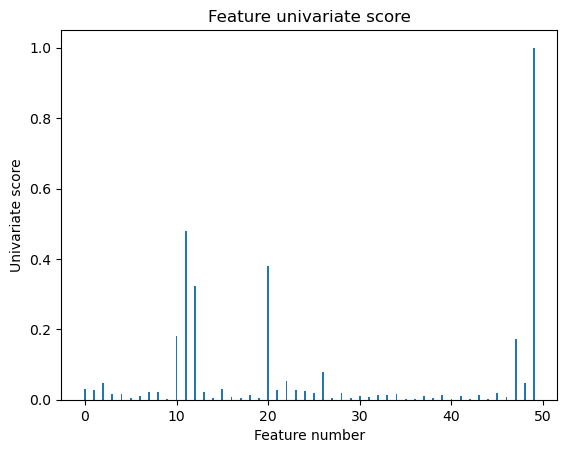

In [100]:
import matplotlib.pyplot as plt

X_indices = np.arange(X_prepared.shape[-1])
plt.figure(1)
plt.clf()
plt.bar(X_indices, scores, width=0.2)
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score")
plt.savefig('Feature_Score_' + exp + '.png', bbox_inches='tight')
plt.show()

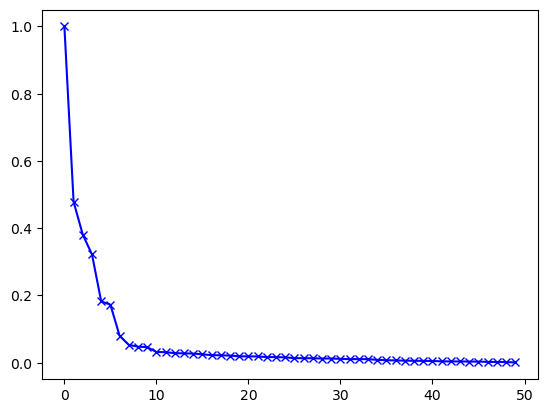

                         name  importance
49              keywords_time    1.000000
11                      money    0.478333
20             discount_entry    0.380760
12                    percent    0.321982
10                       only    0.182264
47             keywords_price    0.172453
26  dominant_color_percentage    0.080048
22      contains_company_name    0.052904
2                         ORG    0.047591
48           keywords_quality    0.046254
15             popup_over_img    0.031738
0                         LOC    0.031278
21             call_to_action    0.028343
1                        MISC    0.027795
23           dominant_color_R    0.027104
24           dominant_color_G    0.024805
8                         now    0.022527
7                       price    0.021938
13         best_and_not_price    0.021111
28     shape_medium_rectangle    0.018936
45       dominant_color_white    0.018693
25           dominant_color_B    0.018611
34       dominant_color_black    0

In [101]:
df_importance = pd.concat([pd.DataFrame(X_prepared.columns[selector.get_support()],
                              columns=["name"]),
                pd.DataFrame(selector.scores_/max(selector.scores_),
                              columns=["importance"])],axis=1).sort_values(by = 'importance', ascending=False)

plt.plot(np.arange(len(selector.scores_)),df_importance.importance,'bx-')
plt.savefig('Feature_Score_sorted_' + exp + '.png', bbox_inches='tight')
plt.show()
print(df_importance)

In [102]:
NER_Features = ["LOC", "MISC", "ORG", "PER"]
SA_Features = ["polarity", "subjectivity"]
Naive_Features = ["best", "price", "now", "new", "only", "money", "percent"]
Combined_Features = ["best_and_not_price", "now_and_not_only"]
Other_Features = ["popup_over_img", "cropped_text", "width", "height", "date_entry", "discount_entry",
                  "call_to_action", "contains_company_name", "dominant_color_R","dominant_color_G","dominant_color_B",
                  "dominant_color_percentage", "shape_banner", "shape_medium_rectangle", "shape_sidebar_ad",
                  "shape_teaser", "shape_wide_skyscraper", "text_style_mixed", "text_style_typed", "dominant_color_black",
                  "dominant_color_blue", "dominant_color_grey", "dominant_color_green", "dominant_color_maroon",
                  "dominant_color_navy", "dominant_color_olive", "dominant_color_purple", "dominant_color_red",
                  "dominant_color_silver", "dominant_color_teal", "dominant_color_white", "dominant_color_yellow"]
KE_Features = ["keywords_price", "keywords_quality", "keywords_time"]

In [103]:
def color(x):
    if x in NER_Features:
        c = 'C3'
    elif x in SA_Features:
        c = 'C4'
    elif x in Naive_Features:
        c = 'C1'
    elif x in Combined_Features:
        c = 'C5'
    elif x in KE_Features:
        c = 'C0'
    elif x in Other_Features:
        c = 'C2'
    else:
        print("ERROR", x)
    return c

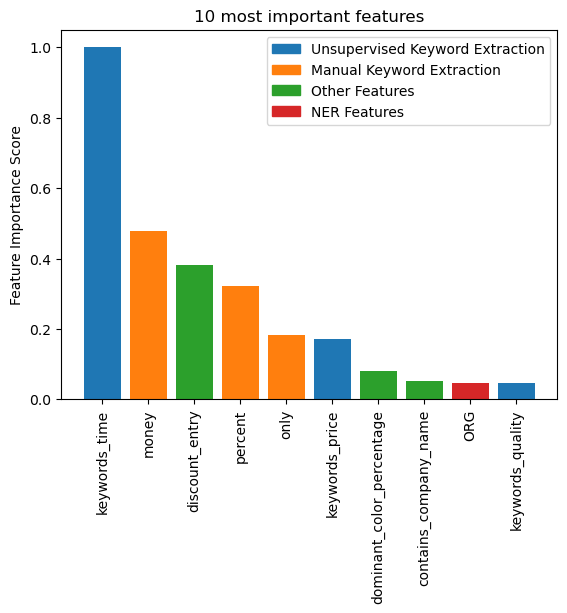

In [104]:
# Plotting the 10 most important features

colors = {'Unsupervised Keyword Extraction':'C0', 'Manual Keyword Extraction':'C1',
          'Other Features':'C2', 'NER Features':'C3'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

c = df_importance["name"][:10].apply(lambda x: color(x))

featureNames = df_importance["name"][:10]
plt.title("10 most important features")
plt.bar(featureNames, df_importance["importance"][:10], color = c)
plt.xticks(range(10), featureNames, rotation='vertical')
plt.ylabel("Feature Importance Score")
plt.savefig('10Features.png', bbox_inches='tight')
plt.show()

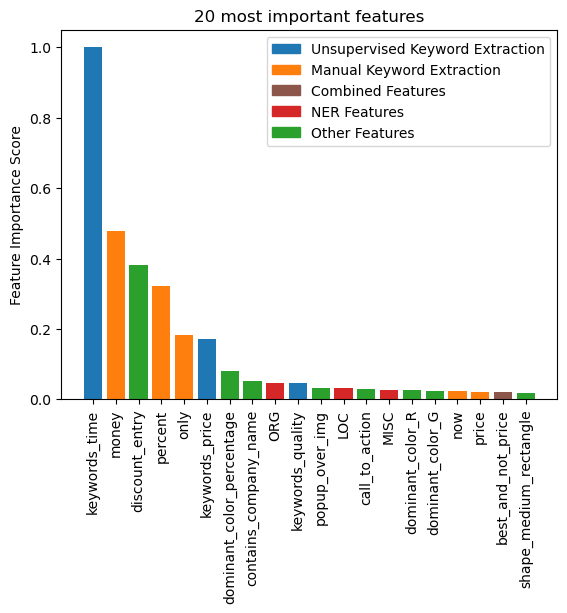

In [105]:
# Plotting the 20 most important features

colors = {'Unsupervised Keyword Extraction':'C0', 'Manual Keyword Extraction':'C1', 'Combined Features':'C5',
          'NER Features':'C3', 'Other Features':'C2'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

c = df_importance["name"][:20].apply(lambda x: color(x))

featureNames = df_importance["name"][:20]
plt.title("20 most important features")
plt.bar(featureNames, df_importance["importance"][:20], color = c)
plt.xticks(range(20), featureNames, rotation='vertical')
plt.ylabel("Feature Importance Score")
plt.savefig('20Features.png', bbox_inches='tight')
plt.show()

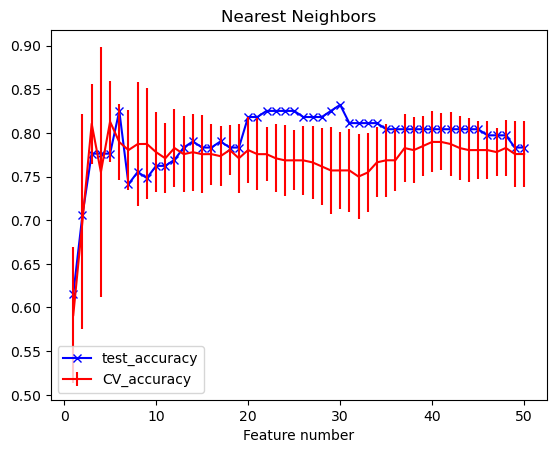

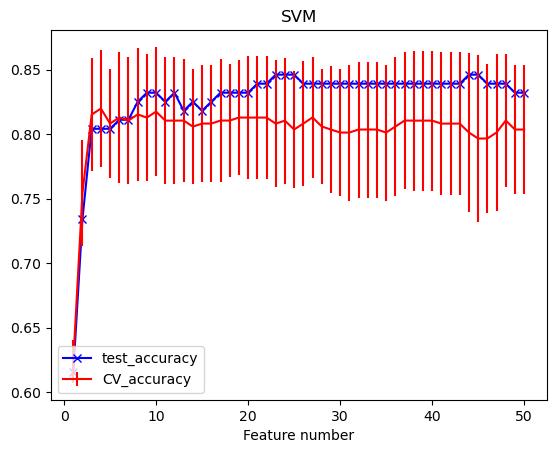

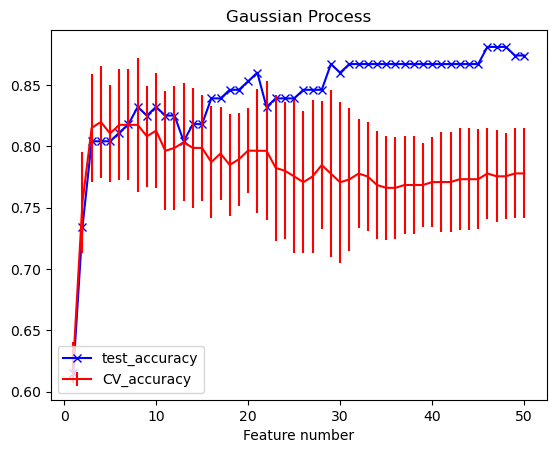

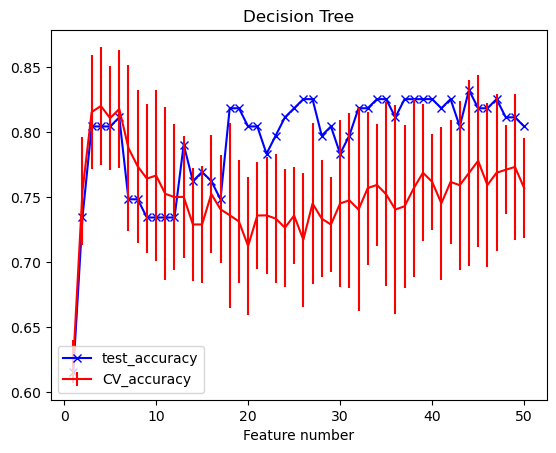

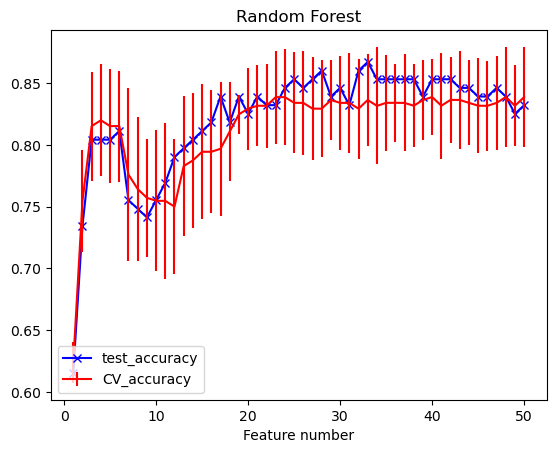

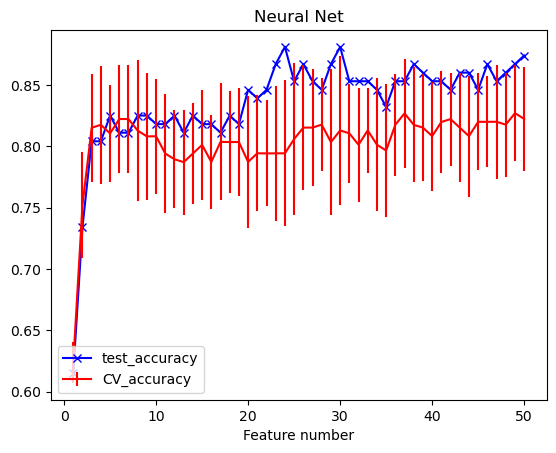

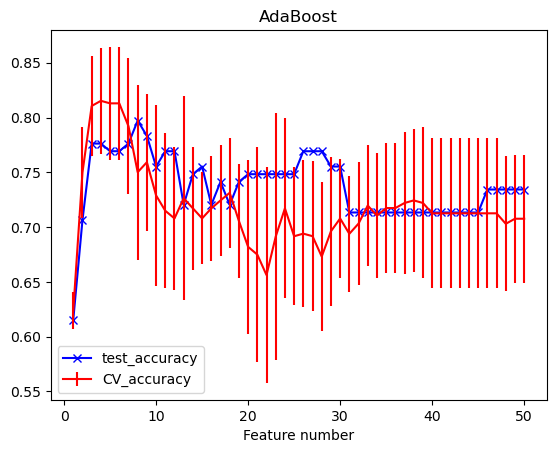

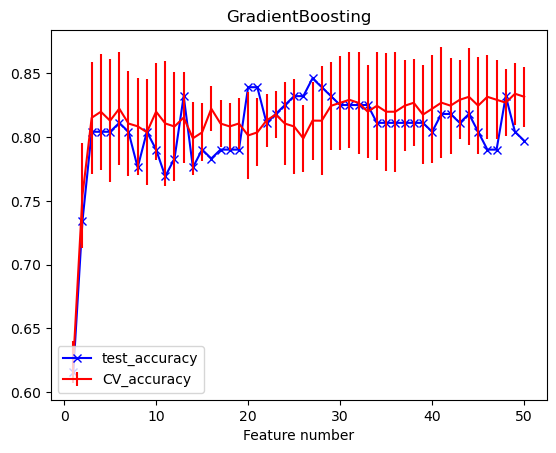

In [106]:
%%capture --no-display 
# Testing different numbers of features
from sklearn.model_selection import cross_val_score

for name, clf in zip(names, classifiers):
    test_accuracy = list()
    score_cv = list()
    score_stds = list()
    
    for i in range(1,len(scores)+1):
        clf_selected = make_pipeline(SelectKBest(f_classif, k=i), clf)
        clf_selected.fit(train_set, train_label)    
        test_accuracy.append(clf_selected.score(test_set, test_label))
        this_scores = cross_val_score(clf_selected, train_set, train_label, cv = 8, n_jobs = -1)
        score_stds.append(this_scores.std())
        score_cv.append(this_scores.mean())   
        print(i,name)
        
    # Plotting
    plt.title(name)
    plt.plot(np.arange(1,len(scores)+1), test_accuracy, 'bx-', label = 'test_accuracy')
    plt.errorbar(np.arange(1,len(scores)+1), score_cv, np.array(score_stds), color = 'r', label = 'CV_accuracy')
    plt.xlabel("Feature number")
    plt.legend(loc='lower left')
    plt.savefig('Feature_Selection_' + exp + '_' + name + '.png', bbox_inches='tight')
    plt.show()
    plt.close()

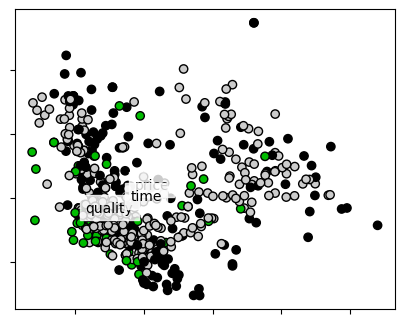

In [107]:
# Test PCA
from sklearn.decomposition import PCA

fig = plt.figure(1, figsize=(4, 3))
plt.clf()

ax = fig.add_subplot(111)
ax.set_position([0, 0, 0.95, 1])


plt.cla()
pca = PCA(n_components=2)
pca.fit(X_prepared)
X_pca = pca.transform(X_prepared)
y_pca = np.zeros_like(y,dtype=int)

for i in range(len(y)):
    if y[i] == "price":
        y_pca[i] = 0
    elif y[i] == "time":
        y_pca[i] = 1
    elif y[i] == "quality":
        y_pca[i] = 2

for name, label in [("price", 0), ("quality", 1), ("time", 2)]:
    ax.text(
        X_pca[y_pca == label, 0].mean(),
        X_pca[y_pca == label, 1].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.8, edgecolor="w", facecolor="w"),
    )
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pca, cmap=plt.cm.nipy_spectral, edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

plt.show()


# Optimizing parameters

## Gridsearch on SVM

In [108]:
# Gridsearch for Nearest Neighbors (takes 16 sec on my PC)
from sklearn.model_selection import GridSearchCV 

parameters_KNN = {'n_neighbors':np.arange(2,10), 'weights':('uniform','distance'),
                  'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute'), 'leaf_size':np.arange(1,101,10),
                  'p':np.arange(1,4)}
clf_KNN = GridSearchCV(KNeighborsClassifier(), parameters_KNN, verbose = 2, n_jobs = -1, cv = 8)
clf_KNN.fit(train_set, train_label)
GridSearch_KNN = pd.concat([pd.DataFrame(clf_KNN.cv_results_["params"]),
                 pd.DataFrame(clf_KNN.cv_results_["mean_test_score"],
                              columns=["Accuracy"])],axis=1).sort_values(by = 'Accuracy', ascending=False, ignore_index=True)
print(GridSearch_KNN)

Fitting 8 folds for each of 1920 candidates, totalling 15360 fits
      algorithm  leaf_size  n_neighbors  p  weights  Accuracy
0          auto         51            3  2  uniform  0.796646
1          auto         91            3  2  uniform  0.796646
2       kd_tree         21            3  2  uniform  0.796646
3     ball_tree         41            3  2  uniform  0.796646
4       kd_tree         51            3  2  uniform  0.796646
...         ...        ...          ... ..      ...       ...
1915  ball_tree         81            9  1  uniform  0.728948
1916  ball_tree          1            9  1  uniform  0.728948
1917  ball_tree         71            9  1  uniform  0.728948
1918      brute         11            9  1  uniform  0.728948
1919      brute         71            9  1  uniform  0.728948

[1920 rows x 6 columns]


In [109]:
# Gridsearch for SVM (takes 1.2 min on my PC) 

parameters_SVC = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':np.linspace(1,8,8),
                  'gamma':[0.001,0.01,0.1,0.5,1.0,3.0], 'coef0':np.linspace(0,2,3),
                  'decision_function_shape':('ovo','ovr')}
clf_SVC = GridSearchCV(SVC(random_state=1), parameters_SVC, verbose = 2, n_jobs = -1, cv = 8)
clf_SVC.fit(train_set, train_label)
GridSearch_SVC = pd.concat([pd.DataFrame(clf_SVC.cv_results_["params"]),
                 pd.DataFrame(clf_SVC.cv_results_["mean_test_score"],
                              columns=["Accuracy"])],axis=1).sort_values(by = 'Accuracy', ascending=False, ignore_index=True)
print(GridSearch_SVC)

Fitting 8 folds for each of 1152 candidates, totalling 9216 fits
        C  coef0 decision_function_shape  gamma   kernel  Accuracy
0     1.0    2.0                     ovr   0.01      rbf  0.824642
1     2.0    0.0                     ovr   0.01      rbf  0.824642
2     3.0    1.0                     ovo   0.01      rbf  0.824642
3     1.0    0.0                     ovr   0.01      rbf  0.824642
4     1.0    2.0                     ovo   0.01      rbf  0.824642
...   ...    ...                     ...    ...      ...       ...
1147  8.0    2.0                     ovo   0.50  sigmoid  0.551450
1148  7.0    2.0                     ovr   0.50  sigmoid  0.549135
1149  7.0    2.0                     ovo   0.50  sigmoid  0.549135
1150  6.0    2.0                     ovo   0.50  sigmoid  0.546864
1151  6.0    2.0                     ovr   0.50  sigmoid  0.546864

[1152 rows x 6 columns]


In [110]:
# Gridsearch for GP (takes 42 sec on my PC)
from sklearn.model_selection import GridSearchCV 

parameters_GP = {'n_restarts_optimizer':[0,1,10,100], 'max_iter_predict':np.arange(100,1000,100),
                 'multi_class':('one_vs_rest','one_vs_one')}
clf_GP = GridSearchCV(GaussianProcessClassifier(random_state=1), parameters_GP, verbose = 2, n_jobs = -1, cv = 8)
clf_GP.fit(train_set, train_label)
Gridsearch_GP = pd.concat([pd.DataFrame(clf_GP.cv_results_["params"]),
                pd.DataFrame(clf_GP.cv_results_["mean_test_score"],
                              columns=["Accuracy"])],axis=1).sort_values(by = 'Accuracy', ascending=False, ignore_index=True)
print(Gridsearch_GP)

Fitting 8 folds for each of 72 candidates, totalling 576 fits
    max_iter_predict  multi_class  n_restarts_optimizer  Accuracy
0                100  one_vs_rest                     0  0.777996
1                100  one_vs_rest                     1  0.777996
2                700   one_vs_one                     0  0.777996
3                700  one_vs_rest                   100  0.777996
4                700  one_vs_rest                    10  0.777996
..               ...          ...                   ...       ...
67               300   one_vs_one                   100  0.777996
68               300   one_vs_one                    10  0.777996
69               300   one_vs_one                     1  0.777996
70               300   one_vs_one                     0  0.777996
71               900   one_vs_one                   100  0.777996

[72 rows x 4 columns]


In [111]:
# Gridsearch for Decision Tree (takes 42 sec on my PC)
from sklearn.model_selection import GridSearchCV 

parameters_DT = {'criterion':('gini','entropy'), 'splitter':['best', 'random'],
                 'max_depth':[3,4,5,10,None], 'max_features':('auto', 'sqrt', 'log2', None, 1, 10),
                 'min_impurity_decrease':np.linspace(0,5,6)}
clf_DT = GridSearchCV(DecisionTreeClassifier(random_state=1), parameters_DT, verbose = 2, n_jobs = -1, cv = 8)
clf_DT.fit(train_set, train_label)
Gridsearch_DT = pd.concat([pd.DataFrame(clf_DT.cv_results_["params"]),
                pd.DataFrame(clf_DT.cv_results_["mean_test_score"],
                              columns=["Accuracy"])],axis=1).sort_values(by = 'Accuracy', ascending=False, ignore_index=True)
print(Gridsearch_DT)

Fitting 8 folds for each of 720 candidates, totalling 5760 fits
    criterion  max_depth max_features  min_impurity_decrease splitter  \
0     entropy        4.0         None                    0.0     best   
1        gini        5.0         None                    0.0     best   
2        gini        3.0         None                    0.0   random   
3     entropy        5.0         None                    0.0     best   
4     entropy        3.0         None                    0.0     best   
..        ...        ...          ...                    ...      ...   
715   entropy        NaN           10                    5.0   random   
716      gini        3.0            1                    0.0   random   
717   entropy        3.0            1                    0.0   random   
718   entropy        4.0            1                    0.0   random   
719      gini        4.0            1                    0.0   random   

     Accuracy  
0    0.817610  
1    0.815295  
2    0.8152

In [112]:
# Gridsearch for Random Forest (takes 6.8 min on my PC)
parameters_Forest = {'n_estimators':[1,10,100,1000], 'criterion':('gini','entropy'),
                  'max_depth':[3,4,5,10,None], 'max_features':('sqrt', 'log2', None, 1, 10),
                  'min_impurity_decrease':np.linspace(0,5,6)}
clf_Forest = GridSearchCV(RandomForestClassifier(random_state=1), parameters_Forest, verbose = 2, n_jobs = -1, cv = 8)
clf_Forest.fit(train_set, train_label)
Gridsearch_Forest = pd.concat([pd.DataFrame(clf_Forest.cv_results_["params"]),
                 pd.DataFrame(clf_Forest.cv_results_["mean_test_score"],
                              columns=["Accuracy"])],axis=1).sort_values(by = 'Accuracy', ascending=False, ignore_index=True)
print(Gridsearch_Forest)

Fitting 8 folds for each of 1200 candidates, totalling 9600 fits
     criterion  max_depth max_features  min_impurity_decrease  n_estimators  \
0         gini        NaN           10                    0.0           100   
1      entropy        NaN         None                    0.0           100   
2      entropy        NaN         sqrt                    0.0           100   
3      entropy        NaN           10                    0.0          1000   
4         gini        NaN           10                    0.0          1000   
...        ...        ...          ...                    ...           ...   
1195   entropy        5.0            1                    0.0             1   
1196      gini        5.0            1                    0.0             1   
1197      gini        4.0            1                    0.0             1   
1198   entropy        4.0            1                    0.0             1   
1199   entropy        3.0         sqrt                    0.0     

In [113]:
# Gridsearch for Neural Net (takes about 60 min on my PC)
parameters_MLP = {'hidden_layer_sizes': [(10,30,10),(20,),(100,)],'activation':('identity','logistic','tanh','relu'),
                  'solver':('lbfgs','sgd','adam'),'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10],
                  'learning_rate':['constant', 'invscaling', 'adaptive'],
                  'learning_rate_init':[0.0001,0.001,0.01,0.1,1,10],'max_iter':[100,200,1000]}
clf_MLP = GridSearchCV(MLPClassifier(random_state=1), parameters_MLP, verbose = 2, n_jobs = -1, cv = 8)
clf_MLP.fit(train_set, train_label)
Gridsearch_MLP = pd.concat([pd.DataFrame(clf_MLP.cv_results_["params"]),
                 pd.DataFrame(clf_MLP.cv_results_["mean_test_score"],
                              columns=["Accuracy"])],axis=1).sort_values(by = 'Accuracy', ascending=False, ignore_index=True)
print(Gridsearch_MLP)

Fitting 8 folds for each of 13608 candidates, totalling 108864 fits
      activation  alpha hidden_layer_sizes learning_rate  learning_rate_init  \
0           relu   0.10             (100,)      adaptive               0.001   
1           relu   0.01             (100,)      constant               0.001   
2           relu   0.10             (100,)    invscaling               0.001   
3           relu   0.01             (100,)    invscaling               0.001   
4           relu   0.01             (100,)      adaptive               0.001   
...          ...    ...                ...           ...                 ...   
13603   identity   0.10              (20,)      constant              10.000   
13604   identity   0.10              (20,)      constant              10.000   
13605   identity   0.10             (100,)      constant              10.000   
13606   identity   0.10             (100,)      constant              10.000   
13607   identity   0.10             (100,)      cons

In [114]:
# Gridsearch for ADA (takes 42 sec on my PC)
from sklearn.model_selection import GridSearchCV 

parameters_ADA = {'n_estimators':[1,50,100,1000], 'learning_rate':[0.1,0.5,1.0,2.0], 'algorithm': ['SAMME', 'SAMME.R']}
clf_ADA = GridSearchCV(AdaBoostClassifier(random_state=1), parameters_ADA, verbose = 2, n_jobs = -1, cv = 8)
clf_ADA.fit(train_set, train_label)
Gridsearch_ADA = pd.concat([pd.DataFrame(clf_ADA.cv_results_["params"]),
                pd.DataFrame(clf_ADA.cv_results_["mean_test_score"],
                              columns=["Accuracy"])],axis=1).sort_values(by = 'Accuracy', ascending=False, ignore_index=True)
print(Gridsearch_ADA)

Fitting 8 folds for each of 32 candidates, totalling 256 fits
   algorithm  learning_rate  n_estimators  Accuracy
0      SAMME            0.1          1000  0.817610
1      SAMME            0.5          1000  0.810622
2      SAMME            1.0           100  0.810535
3      SAMME            1.0            50  0.810404
4      SAMME            0.5           100  0.808220
5      SAMME            0.5            50  0.805949
6      SAMME            0.1           100  0.777952
7      SAMME            0.1            50  0.768606
8      SAMME            1.0          1000  0.756813
9      SAMME            2.0          1000  0.754542
10   SAMME.R            1.0          1000  0.721873
11   SAMME.R            0.5          1000  0.721829
12   SAMME.R            1.0           100  0.714666
13   SAMME.R            0.1          1000  0.707853
14   SAMME.R            1.0            50  0.707591
15     SAMME            0.1             1  0.705538
16   SAMME.R            1.0             1  0.705538
17

In [115]:
# Gridsearch for GB (takes about 120 min on my PC)
from sklearn.model_selection import GridSearchCV 

parameters_GB = {'loss': ('log_loss', 'deviance', 'exponential'),'learning_rate':[0.01,0.1,1,10],
                 'n_estimators':[10,100,1000], 'subsample':[0.1,0.5,1.0],
                 'criterion': ('friedman_mse', 'squared_error'),'max_depth':[3,10,None],
                 'max_features': ('auto', 'sqrt', 'log2'), 'validation_fraction':[0.01,0.1,0.9],
                 'ccp_alpha':[0.0,0.1,1.0,10.0]}
clf_GB = GridSearchCV(GradientBoostingClassifier(random_state=1), parameters_GB, verbose = 2, n_jobs = -1, cv = 8)
clf_GB.fit(train_set, train_label)
Gridsearch_GB = pd.concat([pd.DataFrame(clf_GB.cv_results_["params"]),
                pd.DataFrame(clf_GB.cv_results_["mean_test_score"],
                              columns=["Accuracy"])],axis=1).sort_values(by = 'Accuracy', ascending=False, ignore_index=True)
print(Gridsearch_GB)

Fitting 8 folds for each of 23328 candidates, totalling 186624 fits
       ccp_alpha      criterion  learning_rate         loss  max_depth  \
0            0.0   friedman_mse            0.1     deviance        3.0   
1            0.0  squared_error            0.1     deviance        3.0   
2            0.0  squared_error            0.1     deviance        3.0   
3            0.0  squared_error            0.1     deviance        3.0   
4            0.0   friedman_mse            0.1     deviance        3.0   
...          ...            ...            ...          ...        ...   
23323       10.0  squared_error           10.0  exponential        NaN   
23324       10.0  squared_error           10.0  exponential        NaN   
23325       10.0  squared_error           10.0  exponential        NaN   
23326       10.0  squared_error           10.0  exponential        NaN   
23327       10.0  squared_error           10.0  exponential        NaN   

      max_features  n_estimators  subsample

In [116]:
print('Best parameters found for KNN:\n', clf_KNN.best_params_)
# Exp 1: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 9, 'p': 3, 'weights': 'distance'}
# Exp 2: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 8, 'p': 3, 'weights': 'distance'}
# Exp 3: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
print('Best parameters found for SVM:\n', clf_SVC.best_params_)
# Exp 1: {'C': 1.0, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'gamma': 0.01, 'kernel': 'rbf'}
# Exp 2: {'C': 4.0, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'kernel': 'rbf'}
# Exp 3: {'C': 1.0, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'gamma': 0.01, 'kernel': 'rbf'}
print('Best parameters found for GP:\n', clf_GP.best_params_)
# Exp 1: {'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_restarts_optimizer': 0}
# Exp 2: {'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_restarts_optimizer': 0}
# Exp 3: {'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_restarts_optimizer': 0}
print('Best parameters found for DT:\n', clf_DT.best_params_)
# Exp 1: {'criterion': 'gini', 'max_depth': 10, 'max_features': 10, 'min_impurity_decrease': 0.0, 'splitter': 'best'}
# Exp 2: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_impurity_decrease': 0.0, 'splitter': 'best'}
# Exp 3: {'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'min_impurity_decrease': 0.0, 'splitter': 'best'}
print('Best parameters found for Random Forest:\n', clf_Forest.best_params_)
# Exp 1: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0, 'n_estimators': 1000}
# Exp 2: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_impurity_decrease': 0.0, 'n_estimators': 1000}
# Exp 3: {'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_impurity_decrease': 0.0, 'n_estimators': 100}
print('Best parameters found for Neural Net:\n', clf_MLP.best_params_)
# Exp 1: {'activation': 'logistic', 'alpha': 1, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant',
#         'learning_rate_init': 0.0001, 'max_iter': 200, 'solver': 'lbfgs'}
# Exp 2: {'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant',
#         'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}
# Exp 3: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant',
#         'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}
print('Best parameters found for ADA:\n', clf_ADA.best_params_)
# Exp 1: {'algorithm': 'SAMME', 'learning_rate': 0.5, 'n_estimators': 1000}
# Exp 2: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 1000}
# Exp 3: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 1000}
print('Best parameters found for GB:\n', clf_GB.best_params_)
# Exp 1: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 10,
#         'max_features': 'sqrt', 'n_estimators': 100, 'subsample': 0.5, 'validation_fraction': 0.01}
# Exp 2: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': None,
#         'max_features': 'auto', 'n_estimators': 1000, 'subsample': 0.5, 'validation_fraction': 0.01}
# Exp 3:{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3,
#        'max_features': 'log2', 'n_estimators': 1000, 'subsample': 1.0, 'validation_fraction': 0.01}

Best parameters found for KNN:
 {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Best parameters found for SVM:
 {'C': 1.0, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'gamma': 0.01, 'kernel': 'rbf'}
Best parameters found for GP:
 {'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_restarts_optimizer': 0}
Best parameters found for DT:
 {'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'min_impurity_decrease': 0.0, 'splitter': 'best'}
Best parameters found for Random Forest:
 {'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_impurity_decrease': 0.0, 'n_estimators': 100}
Best parameters found for Neural Net:
 {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}
Best parameters found for ADA:
 {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 1000}
Best parameters found for GB:
 {'ccp_alpha': 0.0

In [117]:
y_true, y_pred = test_label , clf_KNN.predict(test_set)

from sklearn.metrics import classification_report, confusion_matrix
print('Results on the test set:')
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true,y_pred))

Results on the test set:
              precision    recall  f1-score   support

       price       0.86      0.68      0.76        44
     quality       0.81      0.93      0.86        82
        time       0.86      0.71      0.77        17

    accuracy                           0.83       143
   macro avg       0.84      0.77      0.80       143
weighted avg       0.83      0.83      0.82       143

[[30 14  0]
 [ 4 76  2]
 [ 1  4 12]]


In [118]:
y_true, y_pred = test_label , clf_SVC.predict(test_set)

from sklearn.metrics import classification_report, confusion_matrix
print('Results on the test set:')
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true,y_pred))

Results on the test set:
              precision    recall  f1-score   support

       price       0.84      0.70      0.77        44
     quality       0.79      0.89      0.84        82
        time       0.71      0.59      0.65        17

    accuracy                           0.80       143
   macro avg       0.78      0.73      0.75       143
weighted avg       0.80      0.80      0.79       143

[[31 13  0]
 [ 5 73  4]
 [ 1  6 10]]


In [119]:
y_true, y_pred = test_label , clf_Forest.predict(test_set)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true,y_pred))

Results on the test set:
              precision    recall  f1-score   support

       price       0.79      0.75      0.77        44
     quality       0.82      0.89      0.85        82
        time       1.00      0.71      0.83        17

    accuracy                           0.83       143
   macro avg       0.87      0.78      0.82       143
weighted avg       0.83      0.83      0.82       143

[[33 11  0]
 [ 9 73  0]
 [ 0  5 12]]


In [120]:
y_true, y_pred = test_label , clf_MLP.predict(test_set)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true,y_pred))

Results on the test set:
              precision    recall  f1-score   support

       price       0.89      0.75      0.81        44
     quality       0.85      0.95      0.90        82
        time       1.00      0.82      0.90        17

    accuracy                           0.87       143
   macro avg       0.91      0.84      0.87       143
weighted avg       0.88      0.87      0.87       143

[[33 11  0]
 [ 4 78  0]
 [ 0  3 14]]


In [121]:
y_true, y_pred = test_label , clf_ADA.predict(test_set)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true,y_pred))

Results on the test set:
              precision    recall  f1-score   support

       price       0.78      0.70      0.74        44
     quality       0.79      0.85      0.82        82
        time       0.71      0.59      0.65        17

    accuracy                           0.78       143
   macro avg       0.76      0.72      0.73       143
weighted avg       0.77      0.78      0.77       143

[[31 13  0]
 [ 8 70  4]
 [ 1  6 10]]


In [122]:
y_true, y_pred = test_label , clf_GP.predict(test_set)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true,y_pred))

Results on the test set:
              precision    recall  f1-score   support

       price       0.91      0.73      0.81        44
     quality       0.84      0.96      0.90        82
        time       1.00      0.82      0.90        17

    accuracy                           0.87       143
   macro avg       0.92      0.84      0.87       143
weighted avg       0.88      0.87      0.87       143

[[32 12  0]
 [ 3 79  0]
 [ 0  3 14]]


In [123]:
y_true, y_pred = test_label , clf_GB.predict(test_set)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true,y_pred))

Results on the test set:
              precision    recall  f1-score   support

       price       0.75      0.75      0.75        44
     quality       0.85      0.88      0.86        82
        time       1.00      0.82      0.90        17

    accuracy                           0.83       143
   macro avg       0.87      0.82      0.84       143
weighted avg       0.84      0.83      0.83       143

[[33 11  0]
 [10 72  0]
 [ 1  2 14]]


In [124]:
# Werte abspeichern
GridSearch_KNN.to_csv('Gridsearch_' + exp + '_KNN.csv')
GridSearch_SVC.to_csv('Gridsearch_' + exp + '_SVC.csv')
Gridsearch_DT.to_csv('Gridsearch_' + exp + '_DT.csv')
Gridsearch_Forest.to_csv('Gridsearch_' + exp + '_Forest.csv')
Gridsearch_MLP.to_csv('Gridsearch_' + exp + '_MLP.csv')
Gridsearch_ADA.to_csv('Gridsearch_' + exp + '_ADA.csv')
Gridsearch_GP.to_csv('Gridsearch_' + exp + '_GP.csv')
Gridsearch_GB.to_csv('Gridsearch_' + exp + '_GB.csv')


## Comparism of the algorithms

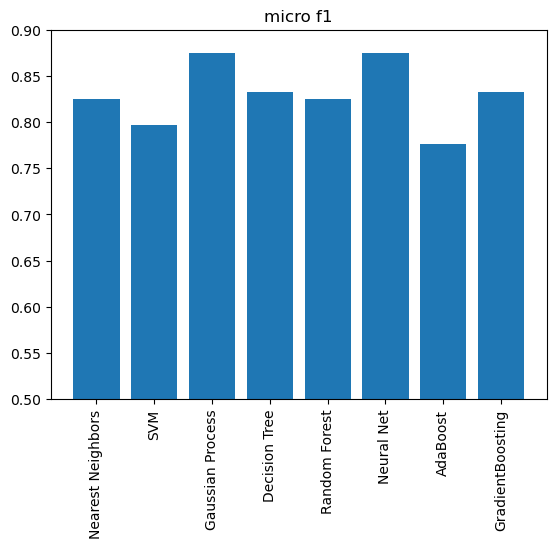

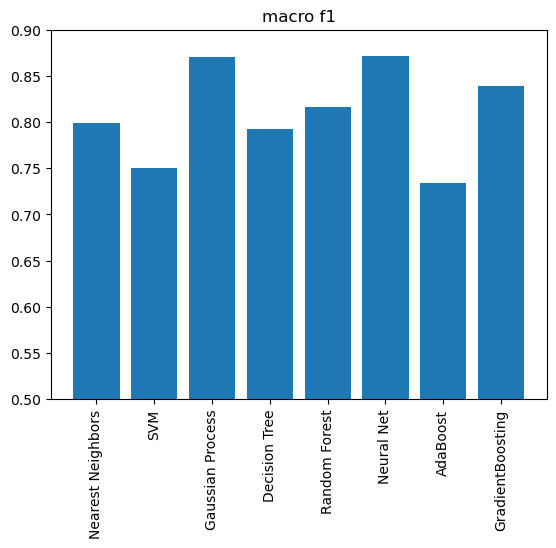

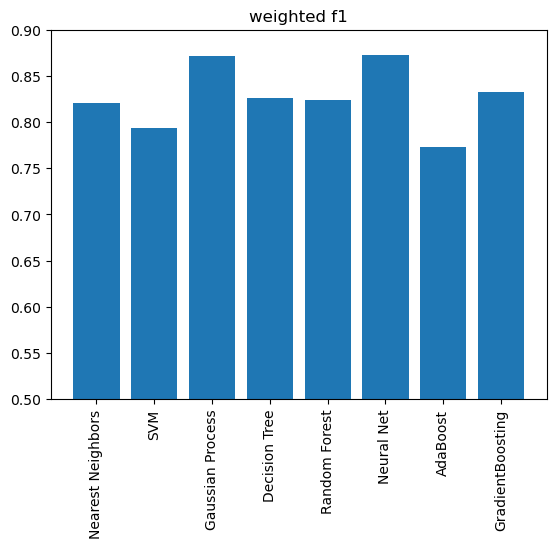

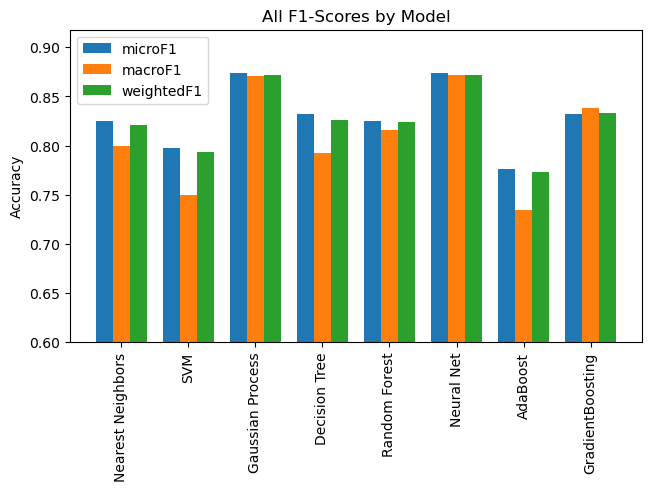

In [125]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

predictors = [clf_KNN, clf_SVC, clf_GP, clf_DT, clf_Forest, clf_MLP, clf_ADA, clf_GB]

micro_f1 = np.zeros((8,))
macro_f1 = np.zeros((8,))
weighted_f1 = np.zeros((8,))
i = 0
clf_KNN.predict(test_set)

for name, clf in zip(names, predictors):
    y_true, y_pred = test_label, clf.predict(test_set)
    micro_f1[i] = f1_score(y_true, y_pred, average = 'micro')
    macro_f1[i] = f1_score(y_true, y_pred, average = 'macro')
    weighted_f1[i] = f1_score(y_true, y_pred, average = 'weighted')
    i += 1

plt.title("micro f1")
plt.bar(names, micro_f1)
plt.xticks(range(len(names)), names, rotation='vertical')
plt.ylim(ymax = 0.9, ymin = 0.5)
plt.savefig('Micro_F1_' + exp + '.png', bbox_inches='tight')
plt.show()
plt.title("macro f1")
plt.bar(names, macro_f1)
plt.xticks(range(len(names)), names, rotation='vertical')
plt.ylim(ymax = 0.9, ymin = 0.5)
plt.savefig('Macro_F1_' + exp + '.png', bbox_inches='tight')
plt.show()
plt.title("weighted f1")
plt.bar(names, weighted_f1)
plt.xticks(range(len(names)), names, rotation='vertical')
plt.ylim(ymax = 0.9, ymin = 0.5)
plt.savefig('Weighted_F1_' + exp + '.png', bbox_inches='tight')
plt.show()

f1_scores = {'microF1':micro_f1, 'macroF1':macro_f1, 'weightedF1':weighted_f1}

fig, ax = plt.subplots(layout='constrained')
multiplier = 0
width = 0.25

for name, f1 in f1_scores.items():
    offset = width * multiplier
    rects = ax.bar(np.arange(len(names))+offset, f1, width, label=name)
    # activate this to get labels at the bars
    #ax.bar_label(rects, padding=3, fmt = '%0.2f', fontsize = 'x-small')
    multiplier += 1
    
ax.set_ylabel('Accuracy')
ax.set_title('All F1-Scores by Model')
ax.set_xticks(np.arange(len(names)) + width, names, rotation = 'vertical')
ax.set_yticks(np.arange(0.6,0.9,0.05))
ax.legend(loc='upper left')
ax.set_ylim(ymin=0.6)
plt.savefig('All_F1_' + exp + '.png', bbox_inches='tight')
plt.show()

## Comparism of the Experiments

In [126]:
from sklearn.metrics import f1_score

def calculateF1(clNames, classif, train_set, test_set, train_label, test_label):
    i = 0
    micro_f1 = np.zeros((len(clNames),))
    macro_f1 = np.zeros((len(clNames),))
    weighted_f1 = np.zeros((len(clNames),))
    for name, clf in zip(clNames, classif):
        clf.fit(train_set, train_label)
        y_true, y_pred = test_label, clf.predict(test_set)
        micro_f1[i] = f1_score(y_true, y_pred, average = 'micro')
        macro_f1[i] = f1_score(y_true, y_pred, average = 'macro')
        weighted_f1[i] = f1_score(y_true, y_pred, average = 'weighted')
        i += 1
    return(micro_f1, macro_f1, weighted_f1)

In [127]:
# hard code the best parameters so that Grid Search doesn't have to run everytime
classifiers_Exp1 = [
    KNeighborsClassifier(algorithm= 'auto', leaf_size= 1, n_neighbors= 9, p= 3, weights= 'distance'),
    SVC(C= 1.0, coef0= 0.0, decision_function_shape= 'ovo', gamma= 0.01, kernel= 'rbf', random_state=1),
    GaussianProcessClassifier(max_iter_predict= 100, multi_class= 'one_vs_rest', n_restarts_optimizer= 0,random_state=1),
    DecisionTreeClassifier(criterion= 'gini', max_depth= 10, max_features= 10,
                           min_impurity_decrease= 0.0, splitter= 'best', random_state=1),
    RandomForestClassifier(criterion= 'entropy', max_depth= None, max_features= 'sqrt',
                           min_impurity_decrease= 0.0, n_estimators= 1000, random_state=1),
    MLPClassifier(activation= 'logistic', alpha= 1, hidden_layer_sizes= (20,), learning_rate= 'constant',
                  learning_rate_init= 0.0001, max_iter= 200, solver= 'lbfgs', random_state=1),
    AdaBoostClassifier(algorithm= 'SAMME', learning_rate= 0.5, n_estimators= 1000, random_state=1),
    GradientBoostingClassifier(ccp_alpha= 0.0, criterion= 'friedman_mse', learning_rate= 0.1,
                               loss= 'deviance', max_depth= 10, max_features= 'sqrt',
                               n_estimators= 100, subsample= 0.5, validation_fraction= 0.01, random_state=1),
]

In [128]:
# hard code the best parameters so that Grid Search doesn't have to run everytime
classifiers_Exp2 = [
    KNeighborsClassifier(algorithm= 'auto', leaf_size= 1, n_neighbors= 8, p= 3, weights= 'distance'),
    SVC(C= 4.0, coef0= 0.0, decision_function_shape= 'ovo', gamma= 0.1, kernel= 'rbf', random_state=1),
    GaussianProcessClassifier(max_iter_predict= 100, multi_class= 'one_vs_rest', n_restarts_optimizer= 0,random_state=1),
    DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None,
                           min_impurity_decrease= 0.0, splitter= 'best', random_state=1),
    RandomForestClassifier(criterion= 'gini', max_depth= None, max_features= None,
                           min_impurity_decrease= 0.0, n_estimators= 1000, random_state=1),
    MLPClassifier(activation= 'relu', alpha= 1, hidden_layer_sizes= (100,), learning_rate= 'constant',
                  learning_rate_init= 0.001, max_iter= 200, solver= 'adam', random_state=1),
    AdaBoostClassifier(algorithm= 'SAMME', learning_rate= 0.1, n_estimators= 1000, random_state=1),
    GradientBoostingClassifier(ccp_alpha= 0.0, criterion= 'squared_error', learning_rate= 0.01,
                               loss= 'deviance', max_depth= None, max_features= 'auto',
                               n_estimators= 1000, subsample= 0.5, validation_fraction= 0.01, random_state=1),
]

In [129]:
# hard code the best parameters so that Grid Search doesn't have to run everytime
classifiers_Exp3 = [
    KNeighborsClassifier(algorithm= 'auto', leaf_size= 1, n_neighbors= 3, p= 2, weights= 'uniform'),
    SVC(C= 1.0, coef0= 0.0, decision_function_shape= 'ovo', gamma= 0.01, kernel= 'rbf', random_state=1),
    GaussianProcessClassifier(max_iter_predict= 100, multi_class= 'one_vs_rest', n_restarts_optimizer= 0,random_state=1),
    DecisionTreeClassifier(criterion= 'entropy', max_depth= 4, max_features= None,
                           min_impurity_decrease= 0.0, splitter= 'best', random_state=1),
    RandomForestClassifier(criterion= 'gini', max_depth= None, max_features= 10,
                           min_impurity_decrease= 0.0, n_estimators= 100, random_state=1),
    MLPClassifier(activation= 'relu', alpha= 0.01, hidden_layer_sizes= (100,), learning_rate= 'constant',
                  learning_rate_init= 0.001, max_iter= 200, solver= 'adam', random_state=1),
    AdaBoostClassifier(algorithm= 'SAMME', learning_rate= 0.1, n_estimators= 1000, random_state=1),
    GradientBoostingClassifier(ccp_alpha= 0.0, criterion= 'friedman_mse', learning_rate= 0.1,
                               loss= 'deviance', max_depth= 3, max_features= 'log2',
                               n_estimators= 1000, subsample= 1.0, validation_fraction= 0.01, random_state=1),
]

In [130]:
%%capture --no-display
# Experiment 1
micro_f1_Exp1, macro_f1_Exp1, weighted_f1_Exp1 = calculateF1(names, classifiers_Exp1, X_train, X_test, y_train, y_test)

# Experiment 2
X_train_2 = X_train.join(keywords, how='left')
X_test_2 = X_test.join(keywords, how='left')
X_2 = X.join(keywords, how='left')

X_train_2 = X_train_2.drop(["best", "price", "now", "new", "only",
                            "money", "percent", "best_and_not_price", "now_and_not_only"], axis = 1)
X_test_2 = X_test_2.drop(["best", "price", "now", "new", "only",
                          "money", "percent", "best_and_not_price", "now_and_not_only"], axis = 1)
X_2 = X_2.drop(["best", "price", "now", "new", "only",
                              "money", "percent", "best_and_not_price", "now_and_not_only"], axis = 1) 
micro_f1_Exp2, macro_f1_Exp2, weighted_f1_Exp2 = calculateF1(names, classifiers_Exp2, X_train_2, X_test_2, y_train, y_test)

# Experiment 3
X_train_3 = X_train.join(keywords, how='left')
X_test_3 = X_test.join(keywords, how='left')
X_3 = X.join(keywords, how='left')
micro_f1_Exp3, macro_f1_Exp3, weighted_f1_Exp3 = calculateF1(names, classifiers_Exp3, X_train_3, X_test_3, y_train, y_test)


In [131]:
micro_f1_scores = {'manual KWs':micro_f1_Exp1, 'extracted KWs':micro_f1_Exp2, 'all features':micro_f1_Exp3}
macro_f1_scores = {'manual KWs':macro_f1_Exp1, 'extracted KWs':macro_f1_Exp2, 'all features':macro_f1_Exp3}
weighted_f1_scores = {'manual KWs':weighted_f1_Exp1, 'extracted KWs':weighted_f1_Exp2, 'all features':weighted_f1_Exp3}

In [132]:
all_scores = {'Exp1Micro': micro_f1_Exp1, 'Exp1Macro':macro_f1_Exp1, 'Exp1Weighted':weighted_f1_Exp1,
              'Exp2Micro':micro_f1_Exp2, 'Exp2Macro':macro_f1_Exp2, 'Exp2Weighted':weighted_f1_Exp2,
              'Exp3Micro':micro_f1_Exp3, 'Exp3Macro':macro_f1_Exp3, 'Exp3Weighted':weighted_f1_Exp3}
pd.DataFrame(data = all_scores)

,Exp1Micro,Exp1Macro,Exp1Weighted,Exp2Micro,Exp2Macro,Exp2Weighted,Exp3Micro,Exp3Macro,Exp3Weighted
0,0.748252,0.638627,0.723833,0.797203,0.773943,0.788212,0.825175,0.799108,0.820959
1,0.727273,0.507630,0.679436,0.804196,0.766794,0.801164,0.797203,0.749891,0.793366
2,0.818182,0.753305,0.813927,0.832168,0.817671,0.828551,0.874126,0.870360,0.871427
3,0.720280,0.585713,0.698734,0.797203,0.760035,0.786235,0.832168,0.791941,0.826461
4,0.797203,0.729515,0.786416,0.776224,0.757932,0.771717,0.825175,0.816276,0.824113
5,0.790210,0.699492,0.777738,0.797203,0.754050,0.788531,0.874126,0.871531,0.872195
6,0.706294,0.557298,0.678155,0.762238,0.705250,0.748026,0.776224,0.733990,0.773276
7,0.804196,0.734829,0.793016,0.818182,0.798517,0.811138,0.832168,0.838500,0.832597


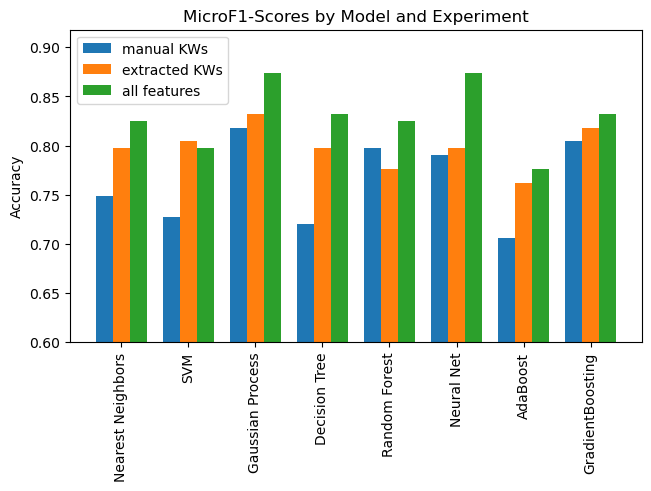

In [139]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(layout='constrained')
multiplier = 0
width = 0.25

for name, f1 in micro_f1_scores.items():
    offset = width * multiplier
    rects = ax.bar(np.arange(len(names))+offset, f1, width, label=name)
    #ax.bar_label(rects, padding=3, fmt = '%0.2f', fontsize = 'x-small')
    multiplier += 1
    
ax.set_ylabel('Accuracy')
ax.set_title('MicroF1-Scores by Model and Experiment')
ax.set_xticks(np.arange(len(names)) + width, names, rotation = 'vertical')
ax.set_yticks(np.arange(0.6,0.9,0.05))
ax.legend(loc='upper left')
ax.set_ylim(ymin=0.6)

plt.savefig('MicroF1_comparism.png', bbox_inches='tight')
plt.show()

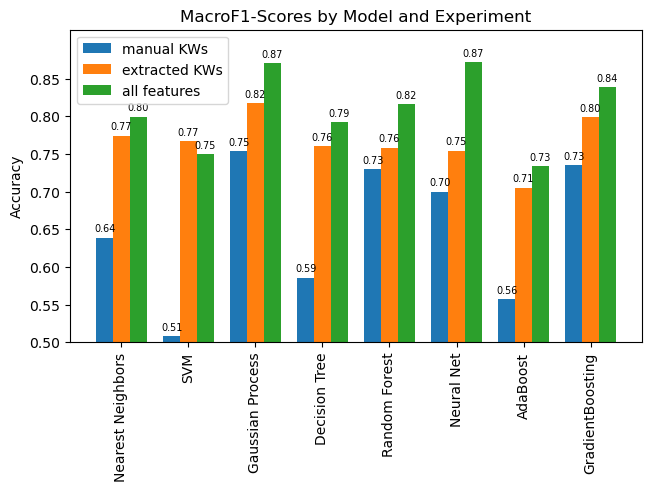

In [134]:
fig, ax = plt.subplots(layout='constrained')
multiplier = 0
width = 0.25

for name, f1 in macro_f1_scores.items():
    offset = width * multiplier
    rects = ax.bar(np.arange(len(names))+offset, f1, width, label=name)
    ax.bar_label(rects, padding=3, fmt = '%0.2f', fontsize = 'x-small')
    multiplier += 1
    
ax.set_ylabel('Accuracy')
ax.set_title('MacroF1-Scores by Model and Experiment')
ax.set_xticks(np.arange(len(names)) + width, names, rotation = 'vertical')
ax.set_yticks(np.arange(0.5,0.9,0.05))
ax.legend(loc='upper left')
ax.set_ylim(ymin=0.5)

plt.savefig('MacroF1_comparism.png', bbox_inches='tight')
plt.show()

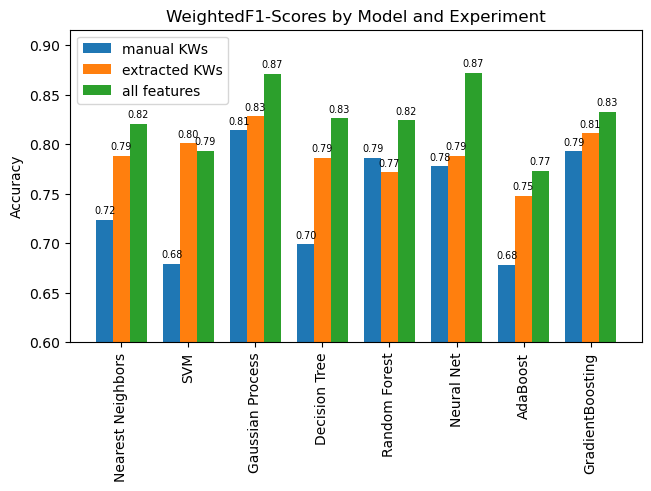

In [135]:
fig, ax = plt.subplots(layout='constrained')
multiplier = 0
width = 0.25

for name, f1 in weighted_f1_scores.items():
    offset = width * multiplier
    rects = ax.bar(np.arange(len(names))+offset, f1, width, label=name)
    ax.bar_label(rects, padding=3, fmt = '%0.2f', fontsize = 'x-small')
    multiplier += 1
    
ax.set_ylabel('Accuracy')
ax.set_title('WeightedF1-Scores by Model and Experiment')
ax.set_xticks(np.arange(len(names)) + width, names, rotation = 'vertical')
ax.set_yticks(np.arange(0.6,0.9,0.05))
ax.legend(loc='upper left')
ax.set_ylim(ymin=0.6)

plt.savefig('WeightedF1_comparism.png', bbox_inches='tight')
plt.show()

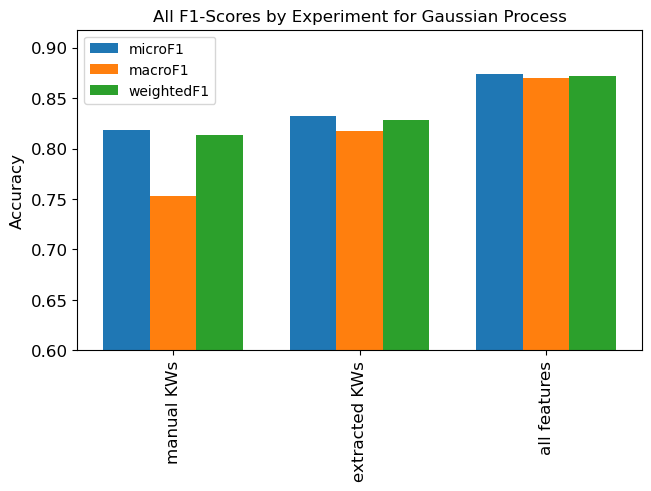

In [136]:
micro_f1_GP = [micro_f1_Exp1[2], micro_f1_Exp2[2], micro_f1_Exp3[2]]
macro_f1_GP = [macro_f1_Exp1[2], macro_f1_Exp2[2], macro_f1_Exp3[2]]
weighted_f1_GP = [weighted_f1_Exp1[2], weighted_f1_Exp2[2], weighted_f1_Exp3[2]]

GP_scores = {'microF1':micro_f1_GP, 'macroF1':macro_f1_GP, 'weightedF1':weighted_f1_GP}
names2 = ["manual KWs", "extracted KWs", "all features"]

fig, ax = plt.subplots(layout='constrained')
multiplier = 0
width = 0.25

for name, f1 in GP_scores.items():
    offset = width * multiplier
    rects = ax.bar(np.arange(len(names2))+offset, f1, width, label=name)
    # activate this to see labels at the bars
    #ax.bar_label(rects, padding=3, fmt = '%0.2f')
    multiplier += 1
    
ax.set_ylabel('Accuracy')
ax.yaxis.label.set_size('large')
ax.set_title('All F1-Scores by Experiment for Gaussian Process')
ax.set_xticks(np.arange(len(names2)) + width, names2, rotation = 'vertical')
ax.xaxis.label.set_size('large')
ax.set_yticks(np.arange(0.6,0.9,0.05))
ax.tick_params(axis='both', which='major', labelsize='large')
ax.legend(loc='upper left')
ax.set_ylim(ymin=0.6)

plt.savefig('GP_F1_Scores.png', bbox_inches='tight')
plt.show()

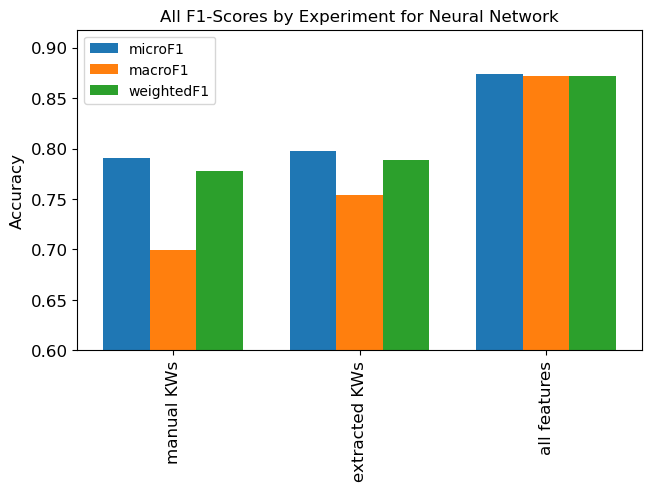

In [137]:
micro_f1_MLP = [micro_f1_Exp1[5], micro_f1_Exp2[5], micro_f1_Exp3[5]]
macro_f1_MLP = [macro_f1_Exp1[5], macro_f1_Exp2[5], macro_f1_Exp3[5]]
weighted_f1_MLP = [weighted_f1_Exp1[5], weighted_f1_Exp2[5], weighted_f1_Exp3[5]]

MLP_scores = {'microF1':micro_f1_MLP, 'macroF1':macro_f1_MLP, 'weightedF1':weighted_f1_MLP}
names2 = ["manual KWs", "extracted KWs", "all features"]

fig, ax = plt.subplots(layout='constrained')
multiplier = 0
width = 0.25

for name, f1 in MLP_scores.items():
    offset = width * multiplier
    rects = ax.bar(np.arange(len(names2))+offset, f1, width, label=name)
    # activate this to see labels at the bars
    #ax.bar_label(rects, padding=3, fmt = '%0.2f')
    multiplier += 1
    
ax.set_ylabel('Accuracy')
ax.yaxis.label.set_size('large')
ax.set_title('All F1-Scores by Experiment for Neural Network')
ax.set_xticks(np.arange(len(names2)) + width, names2, rotation = 'vertical')
ax.xaxis.label.set_size('large')
ax.set_yticks(np.arange(0.6,0.9,0.05))
ax.tick_params(axis='both', which='major', labelsize='large')
ax.legend(loc='upper left')
ax.set_ylim(ymin=0.6)

plt.savefig('MLP_F1_Scores.png', bbox_inches='tight')
plt.show()

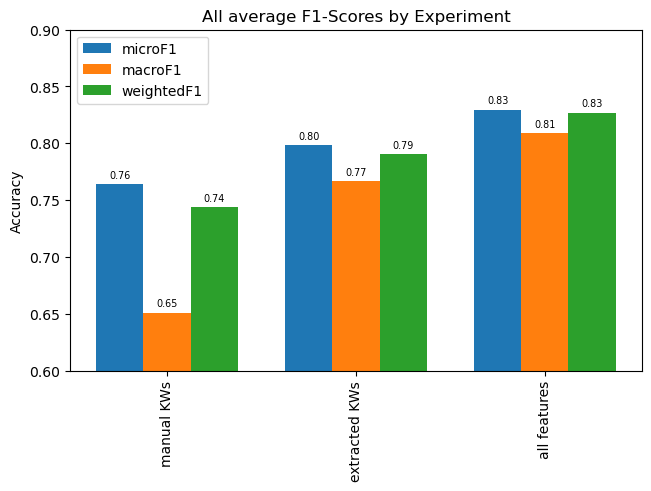

In [138]:
from statistics import mean 

micro_f1_avg = [mean(micro_f1_Exp1), mean(micro_f1_Exp2), mean(micro_f1_Exp3)]
macro_f1_avg = [mean(macro_f1_Exp1), mean(macro_f1_Exp2), mean(macro_f1_Exp3)]
weighted_f1_avg = [mean(weighted_f1_Exp1), mean(weighted_f1_Exp2), mean(weighted_f1_Exp3)]

GP_scores = {'microF1':micro_f1_avg, 'macroF1':macro_f1_avg, 'weightedF1':weighted_f1_avg}
names2 = ["manual KWs", "extracted KWs", "all features"]

fig, ax = plt.subplots(layout='constrained')
multiplier = 0
width = 0.25

for name, f1 in GP_scores.items():
    offset = width * multiplier
    rects = ax.bar(np.arange(len(names2))+offset, f1, width, label=name)
    ax.bar_label(rects, padding=3, fmt = '%0.2f', fontsize = 'x-small')
    multiplier += 1
    
ax.set_ylabel('Accuracy')
ax.set_title('All average F1-Scores by Experiment')
ax.set_xticks(np.arange(len(names2)) + width, names2, rotation = 'vertical')
ax.set_yticks(np.arange(0.6,0.9,0.05))
ax.legend(loc='upper left')
ax.set_ylim(ymin=0.6)

plt.savefig('Mean_F1_Scores.png', bbox_inches='tight')
plt.show()